[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array 

RMSE: 4.34


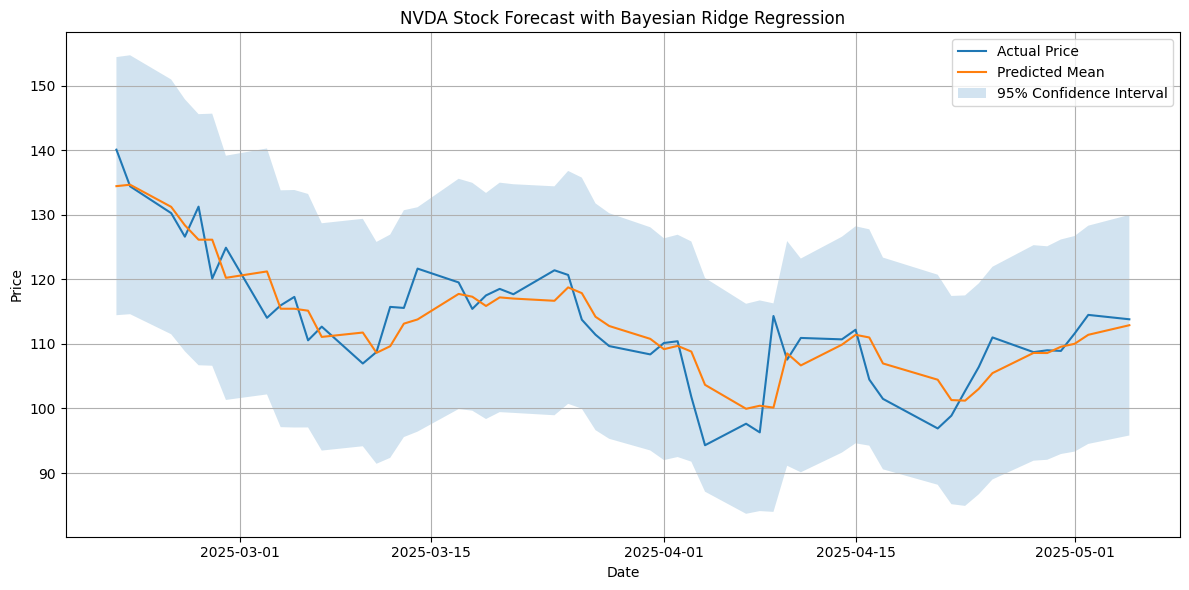

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load NVIDIA data
ticker = "NVDA"
df = yf.download(ticker, period="3mo", interval="1d")

# Step 2: Feature engineering
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()
df.dropna(inplace=True)

X = df[['Lag1', 'Lag2', 'MA5', 'MA10']]
y = df['Close']

# Step 3: Train-test split (time series aware)
tscv = TimeSeriesSplit(n_splits=5)

# Step 4: Define Bayesian Ridge Regression with parameter grid
model = BayesianRidge()
param_dist = {
    "alpha_1": np.logspace(-6, -2, 100),
    "lambda_1": np.logspace(-6, -2, 100)
}

search = RandomizedSearchCV(model, param_distributions=param_dist,
                            n_iter=20, cv=tscv, scoring="neg_mean_squared_error", random_state=42)
search.fit(X, y)

best_model = search.best_estimator_

# Step 5: Predict with uncertainty
y_mean, y_std = best_model.predict(X, return_std=True)

# Step 6: Evaluate
rmse = np.sqrt(mean_squared_error(y, y_mean))
print(f"RMSE: {rmse:.2f}")

# Step 7: Plot predictions with uncertainty
plt.figure(figsize=(12, 6))
plt.plot(df.index, y, label="Actual Price")
plt.plot(df.index, y_mean, label="Predicted Mean")
plt.fill_between(df.index, y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.2, label="95% Confidence Interval")
plt.title("NVDA Stock Forecast with Bayesian Ridge Regression")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Explanation of Probabilistic Modeling:
Bayesian Ridge estimates not just the weights, but their distributions.

This gives mean predictions + standard deviation, allowing us to generate confidence intervals around the forecast.

Prediction intervals are key in financial modeling, where uncertainty matters.